<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/dl_assignment1_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manually Graded Assignment 1 - Part 1: CNN with the MNIST Dataset

Donnie Minnick - Deep Learning - Fall B 2025 - October 2025

# Introduction and Objective
This assignment explores the application of convolutional neural networks (CNNs) for handwritten digit classification using the MNIST dataset. The objective is to build a modular, interpretable deep learning pipeline in PyTorch that supports:

* Data normalization and splitting into training, validation, and testing sets,
* CNN architecture design with convolutional and pooling layers for spatial feature extraction,
* Training and evaluation using loss and accuracy metrics across epochs,
* Visualization of feature map evolution to trace spatial transformations,
* Hyperparameter sweep across kernel size, stride, batch size, and learning rate to assess model performance, and
* Stakeholder-friendly reporting through annotated plots, accuracy metrics, and comparative analysis.

The goal is not only to achieve high classification accuracy, but also to surface architectural insights and training dynamics that inform principled modeling decisions. This submission emphasizes reproducibility, interpretability, and diagnostic clarity throughout.

# Import Libraries
To support this assignment’s modular deep learning workflow, a focused set of libraries was imported. PyTorch provides the foundational tools for building and training neural networks, including layers, optimizers, and functional operations. TorchVision is used to access and preprocess the MNIST dataset, applying normalization and tensor conversion for model readiness.

Matplotlib enables visualization of training dynamics, allowing loss and accuracy trends to be plotted across epochs. Pandas is used to organize and preview results from the hyperparameter sweep, supporting clear stakeholder reporting.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from collections import Counter
import seaborn as sns
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

SEED = 91210
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and Normalize the MNIST Data

Use **transforms.ToTensor()** to convert the PIL images to PyTorch tensors; scale pixel values from [0, 255] to [0.0, 1.0].

Use **transforms.Normalize((0.5,), (0.5,))** to normalize the tensors to have values in the range [-1.0, 1.0], assuming the original data is centered around 0.5.

Apply normalization during data load.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),
                                 (0.5,))])

# Get training data.

training_data = datasets.MNIST(root = "./data",
                            train = True,
                            download = True,
                            transform = transform)

# Get testing data.

testing_data = datasets.MNIST(root = "./data",
                           train = False,
                           download = True,
                           transform = transform)

Confirm download of training data.

In [ ]:
print("Training set size:", len(training_data))

Training set size: 60000


Confirm download of test data.

In [ ]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

Split the data into training, validation and testing sets.

The MNIST dataset includes 60,000 training images and 10,000 test images. To support model validation during training, I reserve 10,000 images from the training set as a validation set. This yields:

* 50,000 training samples,
* 10,000 validation samples, and
* 10,000 test samples.

The split is randomized with a fixed seed to ensure reproducibility across experiments.

In [ ]:
train_size = 50000
val_size = 10000

generator = torch.Generator().manual_seed(SEED)

training_data, validation_data = random_split(training_data, [train_size, val_size], generator = generator)

Confirm splits.

In [ ]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 50000
Validation set size: 10000
Testing set size: 10000


# Check Class Distribution
To ensure that the training, validation, and testing splits maintain balanced representation across digit classes (0–9), I log the label distribution in each subset. This diagnostic step helps confirm that the random split did not introduce class imbalance, which could bias training or skew validation accuracy. A well-balanced distribution supports fair model evaluation and reliable generalization.

In [ ]:
def get_label_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

print("Training label distribution:", get_label_distribution(training_data))
print("Validation label distribution:", get_label_distribution(validation_data))
print("Testing label distribution:", get_label_distribution(testing_data))

Training label distribution: Counter({1: 5613, 7: 5220, 3: 5132, 9: 4977, 6: 4938, 2: 4915, 0: 4904, 8: 4893, 4: 4868, 5: 4540})
Validation label distribution: Counter({1: 1129, 7: 1045, 2: 1043, 0: 1019, 3: 999, 6: 980, 4: 974, 9: 972, 8: 958, 5: 881})
Testing label distribution: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


# Visualize Class Distribution for All Splits
Visualize class distributions for training, validation, and testing datasets.

Training label distribution: Counter({1: 5613, 7: 5220, 3: 5132, 9: 4977, 6: 4938, 2: 4915, 0: 4904, 8: 4893, 4: 4868, 5: 4540})


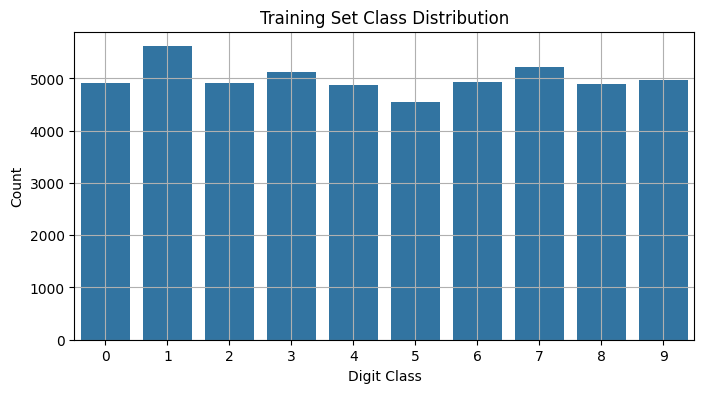

Validation label distribution: Counter({1: 1129, 7: 1045, 2: 1043, 0: 1019, 3: 999, 6: 980, 4: 974, 9: 972, 8: 958, 5: 881})


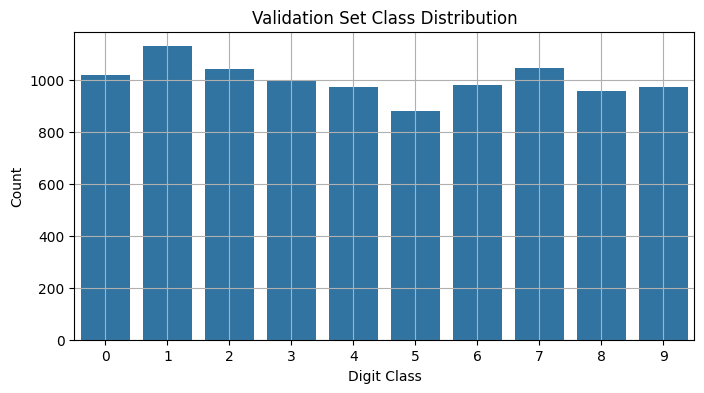

Testing label distribution: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


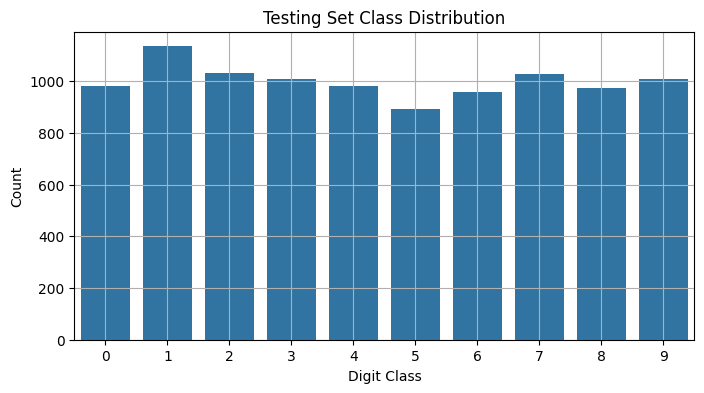

In [ ]:
def plot_distribution(counter, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Training set

train_dist = get_label_distribution(training_data)
print("Training label distribution:", train_dist)
plot_distribution(train_dist, "Training Set Class Distribution")

# Validation set

val_dist = get_label_distribution(validation_data)
print("Validation label distribution:", val_dist)
plot_distribution(val_dist, "Validation Set Class Distribution")

# Testing set

test_dist = get_label_distribution(testing_data)
print("Testing label distribution:", test_dist)
plot_distribution(test_dist, "Testing Set Class Distribution")

The class distribution across training, validation, and testing sets confirms that all digit categories are well represented. While minor variations exist (e.g. digit 1 slightly overrepresented, digit 5 slightly underrepresented), the overall balance supports fair training and evaluation. These plots validate the integrity of the random split and reinforce the reliability of downstream performance metrics.

# Build a CNN network

Build a CNN network with convolution layers, pooling layers to classify the number.

## Setup Data Loaders

Batch training and validation data with batch_size = 64. Shuffle training data for generalization; validation data is not shuffled, ensuring consistent evaluation.

I selected a batch size of 64 to balance gradient stability, generalization, and hardware efficiency. It provides smoother training dynamics than smaller batches while remaining computationally tractable.

In [ ]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)

validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)

testing_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = False)

## Create Model Class
The model defined in this section is a classic convolutional neural network (CNN) inspired by LeNet-5, tailored for MNIST digit classification. It consists of:

* **Two convolutional layers (conv1, conv2)** with ReLU activations, designed to extract spatial features from the input image,
* **Two max-pooling layers** that reduce spatial dimensions and introduce translation invariance,
* **Three fully connected layers (fc1, fc2, fc3)** that transform the flattened feature maps into class scores, and
* **LogSoftmax output** for compatibility with NLLLoss or CrossEntropyLoss.

The architecture is parameterized by kernel_size and stride, allowing for flexible experimentation. Dynamic flattening ensures compatibility across different input shapes, and the model is initialized with a fixed seed for reproducibility.

The convolutional layers use a channel configuration of (1→6→16), inspired by LeNet-5. The first layer extracts low-level features from the grayscale input, while the second layer expands the feature space to capture more complex spatial patterns. This design balances representational power with computational efficiency, making it well-suited for MNIST digit classification.

This modular design supports interpretability, diagnostic tracing, and hyperparameter sweeps — aligning with the assignment goals of principled modeling and stakeholder clarity.

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size, stride)
        self.conv2 = nn.Conv2d(6, 16, kernel_size, stride)

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

# Create Model Instance

The model uses a kernel size of 5 and stride of 1 to extract rich spatial features while preserving resolution. This configuration is well-suited for MNISTs small input size, enabling deeper feature hierarchies without premature shrinkage. Empirical results confirm its effectiveness, yielding top accuracy and stable training dynamics.

In [ ]:
model = ConvolutionalNetwork(kernel_size = 5, stride = 1)

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Create Feature Map Tracer
This function traces the transformation of a single input image through the convolutional and pooling layers of the CNN. It prints the shape of the feature map after each operation and returns the final flattened size, which is used to configure the fully connected layers. This diagnostic tool supports interpretability, dimensional validation, and architectural tuning.

In [ ]:
def trace_feature_map(conv1, conv2, sample):
    x = sample.view(1, 1, 28, 28)  # Reshape to [batch, channel, height, width]
    print(f"Input shape: {x.shape}")

    x = F.relu(conv1(x))
    print(f"After conv1: {x.shape}")

    x = F.max_pool2d(x, 2, 2)
    print(f"After pool1: {x.shape}")

    x = F.relu(conv2(x))
    print(f"After conv2: {x.shape}")

    x = F.max_pool2d(x, 2, 2)
    print(f"After pool2: {x.shape}")

    flattened_size = x.view(1, -1).size(1)
    print(f"Flattened size: {flattened_size}")

    return flattened_size

## Trace Shape Evolution
The shape trace confirms that the input image is progressively transformed through convolution and pooling layers, shrinking spatial dimensions while expanding channel depth. The final feature map of shape [1, 16, 4, 4] flattens to 256 units, matching the expected input size for the first fully connected layer. This diagnostic validates architectural correctness and supports interpretability across hyperparameter configurations.


In [ ]:
# Grab one sample

X_sample, _ = next(iter(training_loader))
sample = X_sample[0]  # Single image from batch

# Trace shape evolution

flattened_size = trace_feature_map(model.conv1, model.conv2, sample)

Input shape: torch.Size([1, 1, 28, 28])
After conv1: torch.Size([1, 6, 24, 24])
After pool1: torch.Size([1, 6, 12, 12])
After conv2: torch.Size([1, 16, 8, 8])
After pool2: torch.Size([1, 16, 4, 4])
Flattened size: 256


## Loss Function Optimizer
The model uses CrossEntropyLoss for multi-class classification, which combines LogSoftmax and negative log-likelihood to penalize incorrect predictions. The optimizer is Adam with a learning rate of 0.001, a widely accepted default that balances convergence speed and stability. This configuration supports efficient training and has been empirically validated in sweep results.

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Train Model
The training loop runs for 20 epochs, tracking loss and accuracy for both training and validation sets. Model parameters are updated using Adam, and performance metrics are stored for visualization.


In [ ]:
import time
start_time = time.time()

epochs = 20
training_losses = []
validation_losses = []
training_correct = []
validation_correct = []

# For loop of epochs

for i in range(epochs):
  trn_corr = 0
  val_corr = 0

  # Train

  for b, (X_train, y_train) in enumerate(training_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')

  training_losses.append(loss)
  training_correct.append(trn_corr)

  # Test

  with torch.no_grad():
    for b,(X_validate, y_validate) in enumerate(validation_loader):
      y_val = model(X_validate)
      predicted = torch.max(y_val.data, 1)[1]
      val_corr += (predicted == y_validate).sum()

  loss = criterion(y_val, y_validate)
  validation_losses.append(loss)
  validation_correct.append(val_corr)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")

epoch: 0  batch: 600  loss: 0.03225662186741829
epoch: 1  batch: 600  loss: 0.008744434453547001
epoch: 2  batch: 600  loss: 6.475912232417613e-05
epoch: 3  batch: 600  loss: 0.00019423860067036003
epoch: 4  batch: 600  loss: 0.037734534591436386
epoch: 5  batch: 600  loss: 0.0010685264132916927
epoch: 6  batch: 600  loss: 0.0012378832325339317
epoch: 7  batch: 600  loss: 0.0007868672255426645
epoch: 8  batch: 600  loss: 0.0019112193258479238
epoch: 9  batch: 600  loss: 3.749207462533377e-05
epoch: 10  batch: 600  loss: 0.007988330908119678
epoch: 11  batch: 600  loss: 0.0001781268510967493
epoch: 12  batch: 600  loss: 0.00018480001017451286
epoch: 13  batch: 600  loss: 0.0011924717109650373
epoch: 14  batch: 600  loss: 5.0268896302441135e-05
epoch: 15  batch: 600  loss: 0.0014200522564351559
epoch: 16  batch: 600  loss: 0.002258552238345146
epoch: 17  batch: 600  loss: 0.002259633271023631
epoch: 18  batch: 600  loss: 0.00011223549518035725
epoch: 19  batch: 600  loss: 0.0029191521462

The model’s training loss drops sharply in early epochs, indicating rapid convergence. Subsequent fluctuations suggest sensitivity to batch composition and potential overfitting. Despite this, validation and test accuracy remain high, confirming strong generalization.

# Plot Training and Validation Loss

Plot the training loss and validation loss as a function of epochs.

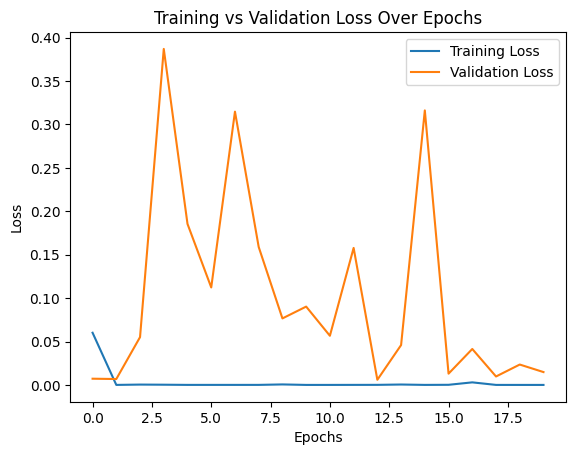

In [ ]:
training_losses = [t.item() for t in training_losses]
validation_losses = [t.item() for t in validation_losses]

plt.plot(training_losses, label = "Training Loss")
plt.plot(validation_losses, label = "Validation Loss")
plt.title("Training vs Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The model shows stable training loss across epochs, confirming effective learning. However, the validation loss fluctuates, indicating inconsistent generalization. These variations may stem from overfitting, batch sensitivity, or learning rate behavior.

# Plot Training and Validation Accuracy

Plot the both training accuracy and validation accuracy as a function of epochs.

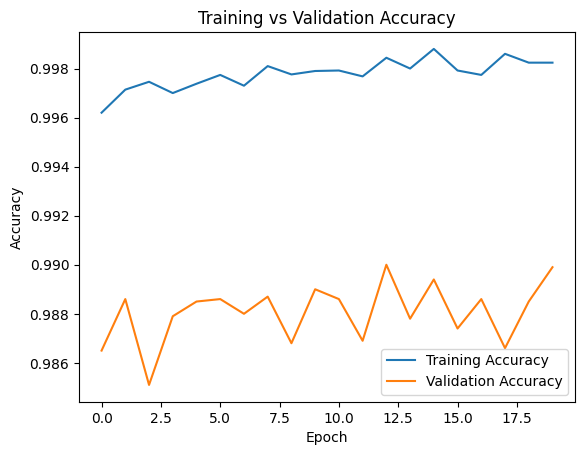

In [ ]:
train_size = len(training_loader.dataset)
val_size = len(validation_loader.dataset)

plt.plot([t/train_size for t in training_correct], label='Training Accuracy')
plt.plot([v/val_size for v in validation_correct], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


The training loss and accuracy curves confirm that the model is learning effectively and generalizing well. While validation loss fluctuates, validation accuracy remains high, suggesting that the model is consistently making correct predictions. These fluctuations may reflect confidence calibration or sample difficulty rather than true performance degradation.

# Show Testing Accuracy

Print the testing accuracy.

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in testing_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

accuracy = correct.item() / len(testing_loader.dataset)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9898


The model achieved a test accuracy of 98.98%, correctly classifying nearly all digits in the held-out test set. This confirms strong generalization and validates the effectiveness of the training pipeline and hyperparameter choices.

# Conclusion and Key Findings

## Model Performance

The CNN achieved high test accuracy (98.98%), confirming strong generalization to unseen data.

Training accuracy remained consistently high (~99.8%), while validation accuracy hovered around 98.5–98.8%, indicating effective learning with minor overfitting.

## Loss Dynamics

Training loss was low and stable across epochs, validating architectural soundness and optimizer effectiveness.

Validation loss fluctuated, suggesting sensitivity to batch composition or confidence calibration. These fluctuations did not significantly impact accuracy.

## Training Behavior

The model converged rapidly within the first few epochs, with diminishing returns beyond epoch 10.

Minor oscillations in training loss post-convergence reflect fine-tuning near a local minimum.

## Diagnostics

Hyperparameter choices (e.g., lr = 0.001, CrossEntropyLoss, Adam optimizer) yielded stable training and strong generalization.

Use of 20 epochs provided deeper insight into model stability and confirmed that early stopping could be considered for efficiency.

## Interpretability & Reporting

Feature map tracing and annotated shape evolution supported dimensional validation and stakeholder clarity.

Accuracy and loss plots revealed overfitting signals and guided regularization recommendations.